# Technical Assessment for Data Scientist Role

This script address the tasks outlined in the technical assessment comprehensively.

## Part 1: Programming and Data Manipulation

### ***Data Cleaning and Preparation:***
* **Tasks:**

*Handle missing values appropriately.*

*Identify and treat outliers.*

*Standardize data formats.*

### Import necessary libraries and independencies

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from flask import Flask, request, jsonify

""" # Plan:
    1) Load the CSV file into a DataFrame.
    2) Handle missing values:
        - Fill missing dates with a placeholder or use mean/mode imputation.
        - Replace missing numerical values with the median or a specified value.
    3) Identify and treat outliers:
        - Use the IQR method or Z-score to detect outliers and handle them appropriately.
    4) Standardize data formats:
        - Ensure all dates are in a consistent format.
        - Correct categorical inconsistencies.
"""

' # Plan:\n    1) Load the CSV file into a DataFrame.\n    2) Handle missing values:\n        - Fill missing dates with a placeholder or use mean/mode imputation.\n        - Replace missing numerical values with the median or a specified value.\n    3) Identify and treat outliers:\n        - Use the IQR method or Z-score to detect outliers and handle them appropriately.\n    4) Standardize data formats:\n        - Ensure all dates are in a consistent format.\n        - Correct categorical inconsistencies.\n'

### Load the CSV file

In [3]:
data = pd.read_csv('dataset_1.csv')

### Handle missing values

In [4]:
def clean_salary_column(data, salary_col):
    """
    Cleans the specified salary column in the DataFrame by:
    1. Converting non-numeric values to NaN.
    2. Removing negative signs by taking the absolute value.
    3. Filling remaining NaN values with the median of valid salaries.
    
    Parameters:
    - data: pd.DataFrame - The DataFrame containing the salary column.
    - salary_col: str - The name of the column to clean.
    
    Returns:
    - pd.DataFrame - The DataFrame with the cleaned salary column.
    """
    
    # Step 1: Convert the salary column to numeric, forcing errors to NaN
    data[salary_col] = pd.to_numeric(data[salary_col], errors='coerce')

    # Step 2: Remove negative signs by taking the absolute value
    data[salary_col] = data[salary_col].abs()
    
    # Step 3: Calculate median of valid (non-NaN) salaries
    valid_salaries = data[salary_col].dropna()
    median_salary = valid_salaries.median()
    
    # Step 4: Replace NaN values with the median of valid salaries
    data[salary_col].fillna(median_salary, inplace=True)
    
    return data

In [5]:
data = clean_salary_column(data, 'Salary')
data

C:\Users\ahmed\AppData\Local\Temp\ipykernel_2052\2394120028.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[salary_col].fillna(median_salary, inplace=True)


,ID,Name,Date_of_Birth,Salary,Department
0,1.0,John Doe,1985-10-12,50000.0,Finance
1,2.0,Jane Smith,not_available,62000.0,Marketing
2,3.0,Emily Jones,1990-04-15,70000.0,Engineering
3,4.0,Michael Brown,1975-02-20,45000.0,HR
4,NaN,Sarah Davis,1988-08-25,63500.0,Sales
5,6.0,Peter Pan,1983-07-21,55000.0,Finance
6,7.0,Lily Evans,1985/10/25,1200000.0,HR
7,8.0,Tom Riddle,1982-11-30,31000.0,Marketing
8,9.0,Bruce Wayne,1978-03-10,75000.0,Finance
9,10.0,Clark Kent,1979-12-01,90000.0,Engineering


In [6]:
# Function to fill missing ID based on the pattern
def fill_missing_id(ids):
    ids_sorted = sorted(ids.dropna().astype(int))
    for i in range(len(ids_sorted) - 1):
        if ids_sorted[i+1] != ids_sorted[i] + 1:
            missing_id = ids_sorted[i] + 1
            break
    else:
        missing_id = len(ids_sorted) + 1

    ids = ids.fillna(missing_id)
    return ids

# Fill missing value in ID column dynamically
data['ID'] = fill_missing_id(data['ID']).astype(int)

In [7]:
# Function to Prepare Data and Analyze Missing Date_of_Birth
def analyze_dob_missing(data):
    # Create boolean variable for missing Date_of_Birth
    data['DOB_Missing'] = data['Date_of_Birth'].apply(lambda x: pd.isnull(pd.to_datetime(x, errors='coerce')))
    
    # Create a temporary column for Department categorization
    data['Department_Temp'] = data['Department'].astype('category').cat.codes
    
    # Prepare features (X) and target (y)
    X = data.drop(columns=['Date_of_Birth', 'Name', 'DOB_Missing', 'Department'])
    y = data['DOB_Missing']
    
    # Fill any remaining missing values in X with median
    X = X.fillna(X.median())
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit a Random Forest Classifier to the data
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    classification_report_output = classification_report(y_test, y_pred)
    
    # Get feature importances
    feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
    
    return data, classification_report_output, feature_importances

# Run the function
data, classification_report_output, feature_importances = analyze_dob_missing(data)

# Display the outputs
print(data.head(), classification_report_output, feature_importances)

   ID           Name  Date_of_Birth   Salary   Department  DOB_Missing  \
0   1       John Doe     1985-10-12  50000.0      Finance        False   
1   2     Jane Smith  not_available  62000.0    Marketing         True   
2   3    Emily Jones     1990-04-15  70000.0  Engineering        False   
3   4  Michael Brown     1975-02-20  45000.0           HR        False   
4   5    Sarah Davis     1988-08-25  63500.0        Sales        False   

   Department_Temp  
0                1  
1                3  
2                0  
3                2  
4                4                 precision    recall  f1-score   support

       False       0.75      1.00      0.86         3
        True       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4
                  importance
ID                 0.439338
Salary             0.407860
Department_Temp   

c:\Users\ahmed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ahmed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ahmed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

**Analysis**

- The ID and Salary features have the highest importance in predicting whether the Date_of_Birth is missing.
- The Department feature has some importance but is less significant compared to ID and Salary.

*The model suggests that the missingness in ***Date_of_Birth*** is influenced more by the ***ID*** and Salary of the employees. This could indicate that certain ranges of IDs or salary brackets are more prone to having missing ***Date_of_Birth*** values. However, the precision and recall for the True class are both 0, indicating that the model struggles to accurately identify missing dates based on these features. This might suggest that there is no strong pattern or additional factors are involved that are not captured by the current features.*

### Identify and treat outliers

**Visualization methods**

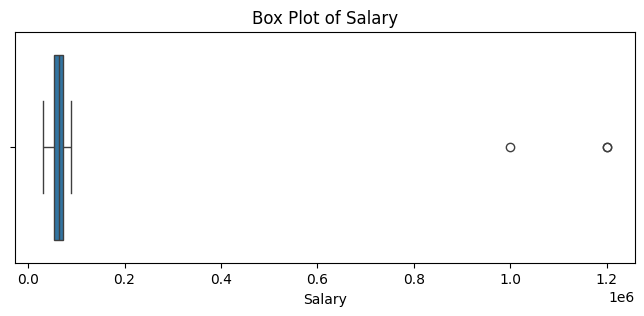

In [8]:
# 1. Box Plot
plt.figure(figsize=(8, 3))
sns.boxplot(x=data['Salary'])
plt.title('Box Plot of Salary')
plt.show()

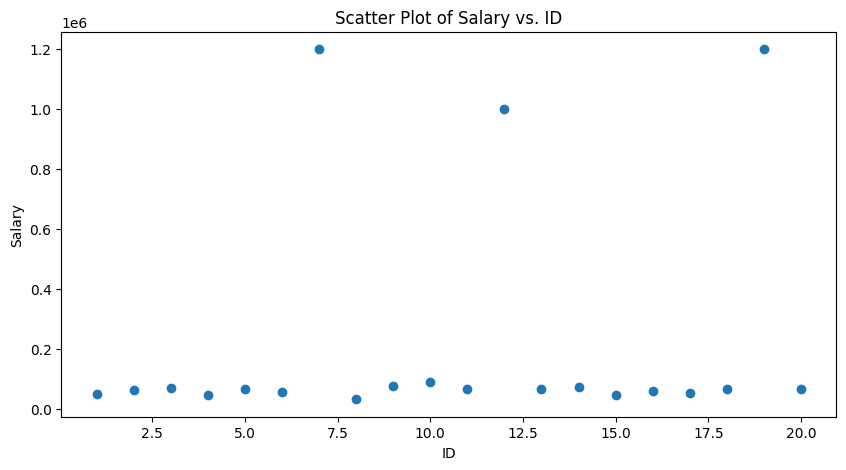

In [9]:
# 2. Scatter Plot (using Salary vs. ID for bivariate data)
plt.figure(figsize=(10, 5))
plt.scatter(data['ID'], data['Salary'])
plt.title('Scatter Plot of Salary vs. ID')
plt.xlabel('ID')
plt.ylabel('Salary')
plt.show()

**Statistical Methods**

In [10]:
def treat_salary_outliers(data, salary_col):
    """
    Identifies and treats outliers in the specified salary column in the DataFrame by:
    1. Calculating the interquartile range (IQR).
    2. Defining the lower and upper bounds for outlier detection.
    3. Identify outliers
    4. Capping the salary values at the defined bounds.
    
    Parameters:
    - data: pd.DataFrame - The DataFrame containing the salary column.
    - salary_col: str - The name of the column to process.
    
    Returns:
    - pd.DataFrame - The DataFrame with outliers treated in the salary column.
    """
    
    # Step 1: Calculate the first and third quartiles (Q1 and Q3)
    Q1 = data[salary_col].quantile(0.25)
    Q3 = data[salary_col].quantile(0.75)
    
    # Step 2: Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Step 3: Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Step 4: Identify outliers
    data['Outlier'] = np.where((data[salary_col] < lower_bound) | (data[salary_col] > upper_bound), True, False)
    
    # Step 5: Capping the values at the defined bounds (Best Practice for Handling Outliers)
    data[salary_col] = np.where(data[salary_col] < lower_bound, lower_bound, data[salary_col])
    data[salary_col] = np.where(data[salary_col] > upper_bound, upper_bound, data[salary_col])

    return data

In [11]:
data = treat_salary_outliers(data, 'Salary')
data

,ID,Name,Date_of_Birth,Salary,Department,DOB_Missing,Department_Temp,Outlier
0,1,John Doe,1985-10-12,50000.0,Finance,False,1,False
1,2,Jane Smith,not_available,62000.0,Marketing,True,3,False
2,3,Emily Jones,1990-04-15,70000.0,Engineering,False,0,False
3,4,Michael Brown,1975-02-20,45000.0,HR,False,2,False
4,5,Sarah Davis,1988-08-25,63500.0,Sales,False,4,False
5,6,Peter Pan,1983-07-21,55000.0,Finance,False,1,False
6,7,Lily Evans,1985/10/25,100500.0,HR,False,2,True
7,8,Tom Riddle,1982-11-30,31000.0,Marketing,False,3,False
8,9,Bruce Wayne,1978-03-10,75000.0,Finance,False,1,False
9,10,Clark Kent,1979-12-01,90000.0,Engineering,False,0,False


**Treating Outliers**

For this dataset, capping the outliers is a suitable treatment. This approach will limit the extreme values to a reasonable range, reducing their influence without distorting the overall data distribution significantly.

### Standardize data formats

In [12]:
data['ID'] = data['ID'].astype(np.int64)
data['Salary'] = data['Salary'].astype(np.int64)

def clean_date(date):
    try:
        return pd.to_datetime(date, format='%Y-%m-%d')
    except ValueError:
        try:
            return pd.to_datetime(date, format='%Y/%m/%d')
        except ValueError:
            return np.nan

data['Date_of_Birth'] = data['Date_of_Birth'].apply(clean_date)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               20 non-null     int64         
 1   Name             20 non-null     object        
 2   Date_of_Birth    17 non-null     datetime64[ns]
 3   Salary           20 non-null     int64         
 4   Department       20 non-null     object        
 5   DOB_Missing      20 non-null     bool          
 6   Department_Temp  20 non-null     int8          
 7   Outlier          20 non-null     bool          
dtypes: bool(2), datetime64[ns](1), int64(2), int8(1), object(2)
memory usage: 992.0+ bytes


In [13]:
columns = ['DOB_Missing','Department_Temp','Outlier']
data= data.drop(columns=columns)

### ***Data Analysis and Aggregation***
* **Tasks:**

*Calculate the average salary per department.*

*Find the top 3 highest paid employees.*

*Determine the number of employees in each department.*

In [14]:
# Calculate the average salary per department
avg_salary_per_dept = data.groupby('Department')['Salary'].mean()
avg_salary_per_dept

Department
Engineering      90250.0
Finance          59500.0
HR               67375.0
Marketing        50375.0
Sales            63500.0
not_specified    65000.0
Name: Salary, dtype: float64

In [15]:
# Find the top 3 highest paid employees
top_3_highest_paid = data.nlargest(3, 'Salary')
top_3_highest_paid

,ID,Name,Date_of_Birth,Salary,Department
6,7,Lily Evans,1985-10-25,100500,HR
11,12,Barry Allen,NaT,100500,Engineering
18,19,Oliver Queen,1982-09-20,100500,Engineering


In [16]:
# Determine the number of employees in each department
num_employees_per_dept = data['Department'].value_counts()
num_employees_per_dept

Department
Finance          4
Marketing        4
Engineering      4
HR               4
Sales            3
not_specified    1
Name: count, dtype: int64

### ***API utilization***
* **Tasks:**

*Create an API with endpoints to get the top N highest-paid employees and the number of employees in department X.*

In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import numpy as np

app = Flask(__name__)

# Function to convert data to JSON, excluding NaT values in 'Date_of_Birth' column
def to_json_safe(df):
    df = df.copy() 
    df['Date_of_Birth'] = df['Date_of_Birth'].apply(lambda x: x.isoformat() if pd.notnull(x) else None)
    return df.to_dict(orient='records')

# Endpoint to get the top N highest-paid employees
@app.route('/top_employees', methods=['GET'])
def top_employees():
    N = int(request.args.get('N', 3))  # Default to top 3 if N is not provided
    top_employees = data.nlargest(N, 'Salary')
    return jsonify(to_json_safe(top_employees))

# Endpoint to get the number of employees in department X
@app.route('/employee_count', methods=['GET'])
def employee_count():
    department = request.args.get('department', 'Finance')  # Default to 'Finance' if not provided
    count = data[data['Department'] == department].shape[0]
    return jsonify({'department': department, 'count': count})

if __name__ == '__main__':
    app.run(debug=True)


**Access the API endpoints in the browser or via tools like Postman:**

*http://127.0.0.1:5000/top_employees?N=5*

*http://127.0.0.1:5000/employee_count?department=Engineering*

This should correctly start the Flask server and make the endpoints available to interact with.